# Deep Neural Learning and Bayesian Optimization of Hyperparameters
###*Optimizing the hyperparameters of a MLP network*
### Mohammad Ali Zamani
### Senior Machine Learning Scientist
 [zamani.ai](https://zamani.ai)
 
Hyperopt parts taken from: https://automl.github.io/HpBandSter/build/html/index.html

some pytorch related part are taken from: https://pytorch.org/tutorials/



In [1]:
!pip install hpbandster

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(100)

# for pytorch
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from typing import NamedTuple
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import copy
import logging
logging.basicConfig(level=logging.INFO)
import os
import pickle
import argparse
import time

# for hyperparameter optimization
import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH
from hpbandster.core.worker import Worker
import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres
from hpbandster.optimizers import BOHB

In [3]:
def twospirals(n_points, difficulty, noise=1.):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * difficulty * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [4]:
class SprialDataSet(Dataset):
    """
    Loading the dataset
    """
    def __init__(self, n_points, difficulty):
        super(SprialDataSet, self).__init__()
        X, Y = twospirals(n_points, difficulty)
        self.set_len = len(X)
        X = torch.from_numpy(X)
        self.input = X.type(torch.float32)
        
        Y = torch.from_numpy(Y)
        Y = Y.unsqueeze(1)
        self.label = Y.type(torch.float32)
    
    def __len__(self):
        return self.set_len

    def __getitem__(self, idx):
        return self.input[idx], self.label[idx]

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


class Optimization():
    def __init__(self, args, loss,  train_loader, val_loader, test_loader):
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        device = args.device

        self.model = MLP(args).to(device)
        
        print("number of trainable parameter = ", count_parameters(self.model))
        
        if args.optimizer == 'Adam':
            self.optimizer = optim.Adam(self.model.parameters(), lr=args.rate)
        elif args.optimizer == 'SGD':
            self.optimizer = torch.optim.SGD(self.model.parameters(), lr=args.rate, momentum=args.sgd_momentum)

        self.scheduler = StepLR(self.optimizer, step_size=args.lr_decay_step)

        self.loss = loss
        self.device = device

    def train(self):
        batch_counter = 0.0
        total_loss = 0.0
        self.model.train()
        for iter, data in enumerate(self.train_loader):
            
            inputs, labels = data 

            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            self.model.zero_grad()
            outputs = self.model(inputs)
            loss = self.loss(outputs, labels)
            loss.backward()

            self.optimizer.step()

            batch_counter += 1
            total_loss += loss.item()
            
        loss_value = total_loss / batch_counter
        return loss_value

    def val_eval(self):
        batch_counter = 0.0
        total_loss = 0.0
        self.model.eval()
        for iter, data in enumerate(self.val_loader):
            inputs, labels = data
            
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            
            # for evaluating the network, we disable the gradient calculation with the no_grad function
            with torch.no_grad():
                outputs = self.model(inputs)
                loss = self.loss(outputs, labels)

            batch_counter += 1
            total_loss += loss.item()

        loss_value = total_loss / batch_counter
        return loss_value

    def test_eval(self, graph=False):
        batch_counter = 0.0
        total_loss = 0.0
        self.model.eval()

        for iter, data in enumerate(self.test_loader):
            inputs, labels = data
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
           
            # for evaluating the network, we disable the gradient calculation with the no_grad function
            with torch.no_grad():
                outputs = self.model(inputs)
                loss = torch.mean((torch.sign(labels - 0.5) * torch.sign(outputs) > 0).type(torch.float32).to(self.device))

            batch_counter += 1
            total_loss += loss
            
           
        loss_value = total_loss / batch_counter
        return loss_value.item()

In [6]:
def main(args, train_loader, val_loader, test_loader):
    device = torch.device(args.device)
    best_val_error = np.inf

    if args.loss == 'BCE':
        loss_function = nn.BCEWithLogitsLoss(reduction='mean')
    elif args.loss == 'NLL':
        loss_function = nn.NLLLoss(reduction='mean')

    optimization = Optimization(args, loss_function, train_loader, val_loader, test_loader)

    train_loss_records = []
    val_loss_records = []
    test_loss_records = []

    print("loading training, val and test set completed!")
    mistake_counter = 0  # mistakes counter for validation loss

    for epoch in range(args.epochs):
        train_loss = optimization.train()
        train_loss_records.append(train_loss)
        optimization.scheduler.step()

        val_loss = optimization.val_eval()
        val_loss_records.append(val_loss)

        test_loss = optimization.test_eval()
        test_loss_records.append(test_loss)

        if epoch > 1:
            if val_loss_records[-1] > val_loss_records[-2]:
                mistake_counter += 1

        if val_loss < best_val_error:
            best_results = {
                'epoch': epoch + 1,
                'state_dict': copy.deepcopy(optimization.model.state_dict()),
                'model': optimization.model,
                'best_val_error': val_loss,
                'best_test_error': test_loss,
                'optimizer': copy.deepcopy(optimization.optimizer),
                'args': args
            }
            best_val_error = val_loss
        print(
            '[Epoch: %3d/%3d] LR: %0.8f  Train loss: %.4f,  Val loss: %.4f,  Test Acc: %.4f'
            % (epoch + 1, args.epochs, optimization.scheduler.get_lr()[0], train_loss_records[epoch], val_loss_records[epoch],
               test_loss_records[epoch]))
        
        if mistake_counter >= args.tol or epoch == args.epochs - 1:
            print('Training is terminated. final epoch or validation loss has increased')
            break
    return test_loss, val_loss

In [7]:
class Args(NamedTuple):
    rate: float  # learning rate
    lr_decay_step: int  # learning rate decay
    batch_size: int  # minibatch size
    epochs: int  # maximum training epochs
    tol: int  # tolerance for the validation error increment
    device: str  # cuda or cpu

    loss: str  # loss function     
    optimizer: str # optimizer method
    sgd_momentum: float #

    dropout: float  # the probability for dropout 
    fc1: int # 1st hidden layer's units
    fc2: int
    fc3: int
    num_layers: int
    # TODO1: add more layers or parameters if necessary

In [8]:
class MLP(nn.Module):
    def __init__(self, args):
        super(MLP, self).__init__()
        self.dropout = nn.Dropout(p=args.dropout)
        self.args = args

        self.fc1 = nn.Linear(2, args.fc1)
        out = args.fc1

        if args.num_layers >= 2:
            self.fc2 = nn.Linear(args.fc1, args.fc2)
            out = args.fc2

        elif args.num_layers == 3:
            self.fc3 = nn.Linear(args.fc2, args.fc3)
            out = args.fc3

        self.fc_out = nn.Linear(out, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        
        if self.args.num_layers >= 2:
          x = self.dropout(torch.relu(self.fc2(x)))

        elif self.args.num_layers >= 3:
          x = self.dropout(torch.relu(self.fc3(x)))
        
        out = self.fc_out(x)
        # TODO5 construct the network here
        return out

In [9]:
class PyTorchWorker(Worker):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
        # initialize the arguments for loading the data
        difficulty = 500
        batch_size = 32

        training_set = SprialDataSet(64, difficulty)
        val_set = SprialDataSet(32, difficulty)
        test_set = SprialDataSet(512, difficulty)

        self.train_loader = DataLoader(training_set, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)
        self.val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=8, shuffle=False, drop_last=True)
        self.test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=8, shuffle=False, drop_last=True)

    def compute(self, config, budget, working_directory, *args, **kwargs):
        """
        testing the configuration
        """
        print("Selected HyperParameters to test: ")
        print(config)
        new_args = Args(
                        rate=config['lr'],
                        lr_decay_step=30,
                        batch_size=32,
                        epochs=int(budget),
                        tol=100,
                        loss='BCE',
                        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),

                        optimizer=config['optimizer'],
                        sgd_momentum= config['sgd_momentum'] if 'sgd_momentum' in config else None,
                        dropout= config['dropout'],
                        fc1=config['fc1'], # 
                        fc2=config['fc2'] if 'fc2' in config else None,
                        fc3=config['fc3'] if 'fc3' in config else None,
                        num_layers=config['num_layers']
                        # TODO2 add the additional parameters from Args class here
                        )
        
        test_loss, val_loss = main(new_args, self.train_loader, self.val_loader, self.test_loader)
        return ({
            'loss': val_loss,  # remember: HpBandSter always minimizes!
            'info': {'test accuracy': test_loss,
                     }
        })

    
    @staticmethod
    def get_configspace():
        """
            It builds the configuration space with the needed hyperparameters
            :return: ConfigurationsSpace-Object
            """
        cs = CS.ConfigurationSpace()

        # TODO3: add a proper condition here
        # Type 1 condition: float
        lr = CSH.UniformFloatHyperparameter('lr', lower=1e-4, upper=1e-1, default_value='1e-2', log=True)
        
        # Type 2 condition: categorical 
        # For demonstration purposes, we add different optimizers as categorical hyperparameters.
        # To show how to use conditional hyperparameters with ConfigSpace, we'll add the optimizers 'Adam' and 'SGD'.
        # SGD has a different parameter 'momentum'.
        optimizer = CSH.CategoricalHyperparameter('optimizer', ['Adam', 'SGD'])

        sgd_momentum = CSH.UniformFloatHyperparameter('sgd_momentum', lower=0.0, upper=0.99, default_value=0.9, log=False)

        cs.add_hyperparameters([lr, optimizer, sgd_momentum])
        #cs.add_hyperparameters([lr])

        # Type 3 condition: conditional
        # The hyperparameter sgd_momentum will be used,if the configuration
        # contains 'SGD' as optimizer.
        cond = CS.EqualsCondition(sgd_momentum, optimizer, 'SGD')
        cs.add_condition(cond)

        # Type 4 condition: Integer
        fc1 = CSH.UniformIntegerHyperparameter('fc1', lower=2, upper=20, default_value=10, log=False)
        fc2 = CSH.UniformIntegerHyperparameter('fc2', lower=2, upper=20, default_value=10, log=False)
        fc3 = CSH.UniformIntegerHyperparameter('fc3', lower=2, upper=20, default_value=10, log=False)
        num_layers = CSH.UniformIntegerHyperparameter('num_layers', lower=1, upper=3, default_value=2, log=False)

        cs.add_hyperparameters([fc1, fc2, fc3, num_layers])

        cond_fc2 = CS.GreaterThanCondition(fc2, num_layers, 1)
        cond_fc3 = CS.GreaterThanCondition(fc3, num_layers, 2)
        cs.add_condition(cond_fc2)
        cs.add_condition(cond_fc3)

        dropout = CSH.UniformFloatHyperparameter('dropout', lower=0, upper=0.9, default_value='0', log=False)
        cs.add_hyperparameters([dropout])
        return cs

In [10]:
# TO record a backup from the old hyperparamter searches
def backup_jsons(curDir):
    for fname in ('results', 'configs'):
        if os.path.exists(curDir + os.path.sep + fname + '.json'):
            counter = 1
            while os.path.exists(curDir + os.path.sep + fname + '_' + str(counter) + '.json'):
                counter += 1
            os.rename(curDir + os.path.sep + fname + '.json', curDir + os.path.sep + fname + '_' + str(counter) + '.json')


args_min_budget = 1 # Minimum number of epochs for training.
args_max_budget = 27 # Maximum number of epochs for training.
args_n_iterations = 3 # Number of iterations performed by the optimizer
args_worker = False # Flag to turn this into a worker process
args_run_id = '' # A unique run id for this optimization run. An easy option is to use the job id of the clusters scheduler.
args_nic_name = 'lo' # Which network interface to use for communication.
args_shared_directory = '.' # A directory that is accessible for all processes, e.g. a NFS share.
args_eta = 3 # eta

# Every process has to lookup the hostname
host = hpns.nic_name_to_host(args_nic_name)


if args_worker:
    import time
    time.sleep(1)   # short artificial delay to make sure the nameserver is already running
    w = PyTorchWorker(run_id=args_run_id, host=host, timeout=120)
    w.load_nameserver_credentials(working_directory=args_shared_directory)
    w.run(background=False)
    exit(0)


# This example shows how to log live results. This is most useful
# for really long runs, where intermediate results could already be
# interesting. The core.result submodule contains the functionality to
# read the two generated files (results.json and configs.json) and
# create a Result object.

#backup_jsons(args_shared_directory)
result_logger = hpres.json_result_logger(directory=args_shared_directory, overwrite=True)

# Start a nameserver:
NS = hpns.NameServer(run_id=args_run_id, host=host, port=0, working_directory=args_shared_directory)
ns_host, ns_port = NS.start()

# Start local worker
w = PyTorchWorker(run_id=args_run_id, host=host, nameserver=ns_host, nameserver_port=ns_port, timeout=120)
w.run(background=True)

# Run an optimizer
bohb = BOHB(  configspace = PyTorchWorker.get_configspace(),
                        run_id = args_run_id,
                        eta = args_eta,
                        host=host,
                        nameserver=ns_host,
                        nameserver_port=ns_port,
                        result_logger=result_logger,
                        min_budget=args_min_budget, 
                        max_budget=args_max_budget,
                        
                        # in case of expecting better result change the following 
                        num_samples = 32, # 1st decrease
                        top_n_percent=25, # 2nd increase 
                        bandwidth_factor=10, # 3rd increase or/and
                        min_bandwidth=1e-3, # 3rd increase
            
               )
res = bohb.run(n_iterations=args_n_iterations)

# store results
with open(os.path.join(args_shared_directory, 'results.pkl'), 'wb') as fh:
    pickle.dump(res, fh)

# shutdown
bohb.shutdown(shutdown_workers=True)
NS.shutdown()

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Selected HyperParameters to test: 
{'dropout': 0.7956881371660035, 'fc1': 8, 'lr': 0.0012322847944916684, 'num_layers': 2, 'optimizer': 'Adam', 'fc2': 6}
number of trainable parameter =  85
loading training, val and test set completed!
[Epoch:   1/  1] LR: 0.00123228  Train loss: 0.9729,  Val loss: 0.7942,  Test Acc: 0.4775
Training is terminated. final epoch or validation loss has increased
Selected HyperParameters to test: 
{'dropout': 0.6903817768031177, 'fc1': 11, 'lr': 0.06989777058656244, 'num_layers': 2, 'optimizer': 'SGD', 'fc2': 20, 'sgd_momentum': 0.6942963079113548}
number of trainable parameter =  294
loading training, val and test set completed!


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:381: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


[Epoch:   1/  1] LR: 0.06989777  Train loss: 0.6842,  Val loss: 0.5851,  Test Acc: 0.6562
Training is terminated. final epoch or validation loss has increased
Selected HyperParameters to test: 
{'dropout': 0.32646064460895496, 'fc1': 14, 'lr': 0.022810600297757926, 'num_layers': 2, 'optimizer': 'SGD', 'fc2': 9, 'sgd_momentum': 0.06182896619664594}
number of trainable parameter =  187
loading training, val and test set completed!
[Epoch:   1/  1] LR: 0.02281060  Train loss: 0.7308,  Val loss: 0.7340,  Test Acc: 0.4893
Training is terminated. final epoch or validation loss has increased
Selected HyperParameters to test: 
{'dropout': 0.4154182385693939, 'fc1': 9, 'lr': 0.00320140675285429, 'num_layers': 3, 'optimizer': 'SGD', 'fc2': 18, 'fc3': 4, 'sgd_momentum': 0.5445802583971601}
number of trainable parameter =  226
loading training, val and test set completed!
[Epoch:   1/  1] LR: 0.00320141  Train loss: 0.8211,  Val loss: 0.7824,  Test Acc: 0.4043
Training is terminated. final epoch o

Best found configuration:
{'dropout': 0.23926990426296638, 'fc1': 12, 'lr': 0.08440803961148495, 'num_layers': 1, 'optimizer': 'Adam'}
It achieved validation loss of 0.272315 and test accuracy of 0.889648 .


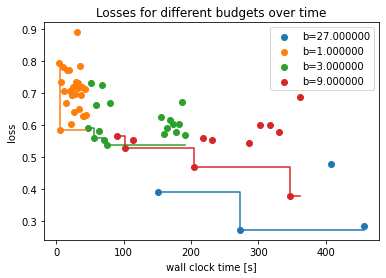

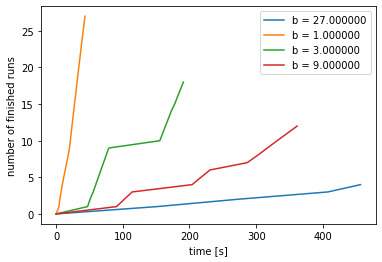

In [11]:
import matplotlib.pyplot as plt
import hpbandster.core.result as hpres
import hpbandster.visualization as hpvis

# load the example run from the log files
result = hpres.logged_results_to_HBS_result('.')

# get all executed runs
all_runs = result.get_all_runs()

# get the 'dict' that translates config ids to the actual configurations
id2conf = result.get_id2config_mapping()


# Here is how you get he incumbent (best configuration)
inc_id = result.get_incumbent_id()

# let's grab the run on the highest budget
inc_runs = result.get_runs_by_id(inc_id)
inc_run = inc_runs[-1]


# We have access to all information: the config, the loss observed during
#optimization, and all the additional information
inc_loss = inc_run.loss
inc_config = id2conf[inc_id]['config']
inc_test_loss = inc_run.info['test accuracy']

print('Best found configuration:')
print(inc_config)
print('It achieved validation loss of %f and test accuracy of %f .'%(inc_loss, inc_test_loss))


# Let's plot the observed losses grouped by budget,
hpvis.losses_over_time(all_runs)

# and the number of finished runs.
hpvis.finished_runs_over_time(all_runs)


plt.show()